In [25]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [26]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [27]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from mpl_toolkits import mplot3d 

# Data Import

In [28]:
data_ori = pd.read_csv("data.csv")
data_ori = data_ori.drop('fid',axis=1)
data_ori.head()

,X,Y,fua_name,road_len,pop2012,night2012,cen_dist,city_id,dem,area,city_pop_total,CLC2012,CLC2018
0,15.141667,37.608333,Acireale,0.030695,7325.648926,30.059999,2692.726152,0,231.122589,170139.971472,65551.679619,1,1
1,15.145834,37.608333,Acireale,0.015920,1882.117426,20.930000,2421.478762,0,212.466461,170139.971472,65551.679619,1,1
2,15.150001,37.608333,Acireale,0.013220,2574.318192,18.379999,2214.927460,0,192.600739,170139.971472,65551.679619,1,1
3,15.154167,37.608333,Acireale,0.023740,7405.131897,28.459999,2092.320938,0,191.244446,170139.971472,65551.679619,1,1
4,15.158334,37.608333,Acireale,0.026380,11867.653831,42.959999,2068.639445,0,186.216003,170139.971472,65551.679619,1,1


In [29]:
data = data_ori.copy()

In [30]:
data.describe()

,X,Y,road_len,pop2012,night2012,cen_dist,city_id,dem,area,city_pop_total,CLC2012,CLC2018
count,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,4.337740e+05,433774.000000,433774.000000
mean,12.181522,42.813994,0.006323,460.922545,6.186208,18926.087893,43.818316,300.308938,157587.105137,9.689037e+05,6.906518,6.904761
std,2.618842,2.454614,0.008254,1854.554564,12.586370,12508.021687,22.376779,363.384209,6091.387820,1.434181e+06,1.857292,1.861171
min,7.287501,36.770833,0.000000,0.000000,0.000000,8.393582,0.000000,-7.660000,147277.182636,5.450901e+04,1.000000,1.000000
25%,10.129167,40.937500,0.000000,0.000000,0.520000,10137.812750,26.000000,52.978625,152266.625668,1.585278e+05,7.000000,7.000000
50%,12.079167,43.154166,0.004151,3.497574,1.400000,16025.843740,44.000000,168.749840,156878.006656,2.276852e+05,7.000000,7.000000
75%,13.816667,44.945833,0.009230,72.863836,5.310000,24585.104749,65.000000,403.033470,162365.625903,7.261099e+05,8.000000,8.000000
max,18.375001,46.820833,0.088460,57586.267532,299.600006,87998.149164,83.000000,3245.634766,172005.019278,4.815786e+06,12.000000,12.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026883192548>,
      dtype=object)

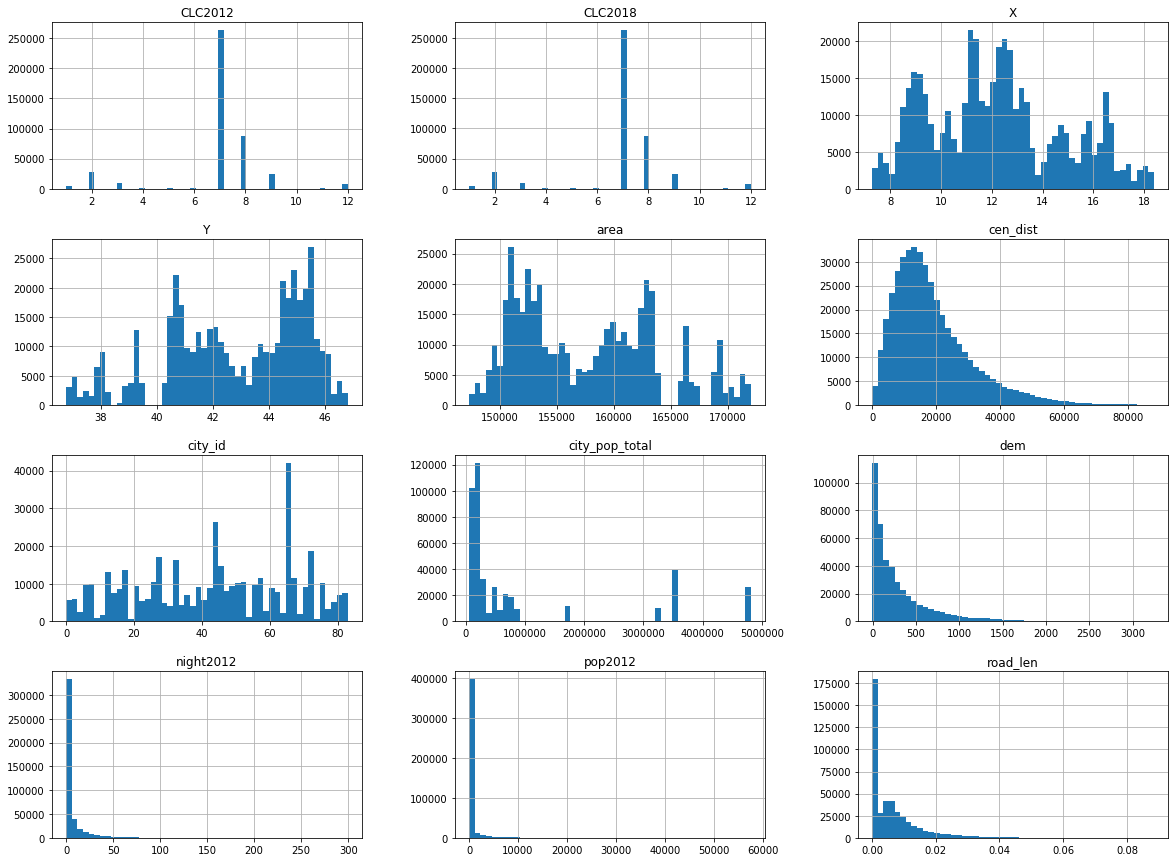

In [31]:
data.hist(bins=50,figsize=(20,15))

# Data Pre-process

In [32]:
dscb_dict = data.describe().to_dict()
night_min = 0
night_max = dscb_dict['night2012']['max']

In [33]:
# StandardScaler will subtract the mean from each value, then scale to the unit variance
scaler = preprocessing.MinMaxScaler()
alist = ['pop2012','road_len','dem','cen_dist','city_pop_total']
data1 = data[alist]
data2 = scaler.fit_transform(data1.values.reshape(-1, len(alist)))
data2 = pd.DataFrame(data2, columns=alist)

In [34]:
# Normalize the night-light in different time with the same standard.
alist = ['night2012',]
for col in alist:
    data2[col] = data[col].apply(lambda x: (x - night_min) / (night_max - night_min))

In [35]:
# Based on different city_id, to normalize the longitude and latitude
alist = ['X','Y']
for col in alist:
    data[col+'_max'] = data.groupby(['city_id'])[col].transform(max)
    data[col+'_min'] = data.groupby(['city_id'])[col].transform(min)
    data2[col] = ((data[col] - data[col+'_min']) / (data[col+'_max'] - data[col+'_min']))

In [36]:
data2['city_id'] = data['city_id']

In [39]:
# Factorize the city id
data2['land_cover'] = data['CLC2012']

In [40]:
data2.head()

,pop2012,road_len,dem,cen_dist,city_pop_total,night2012,X,Y,city_id,land_cover
0,0.127212,0.346998,0.073397,0.030507,0.002319,0.100334,0.30,0.242424,0,1
1,0.032683,0.179969,0.067663,0.027425,0.002319,0.069860,0.35,0.242424,0,1
2,0.044704,0.149444,0.061556,0.025077,0.002319,0.061348,0.40,0.242424,0,1
3,0.128592,0.268370,0.061139,0.023684,0.002319,0.094993,0.45,0.242424,0,1
4,0.206085,0.298220,0.059594,0.023415,0.002319,0.143391,0.50,0.242424,0,1


In [41]:
alist = ['city_id','land_cover','pop2012','X','Y','road_len','night2012','cen_dist','dem','city_pop_total']
data_new = data2[alist]

## Data Export

In [42]:
data_new.to_csv('data_new.csv',index=False)
print('File Exported!')

File Exported!


In [43]:
data_new.head()

,city_id,land_cover,pop2012,X,Y,road_len,night2012,cen_dist,dem,city_pop_total
0,0,1,0.127212,0.30,0.242424,0.346998,0.100334,0.030507,0.073397,0.002319
1,0,1,0.032683,0.35,0.242424,0.179969,0.069860,0.027425,0.067663,0.002319
2,0,1,0.044704,0.40,0.242424,0.149444,0.061348,0.025077,0.061556,0.002319
3,0,1,0.128592,0.45,0.242424,0.268370,0.094993,0.023684,0.061139,0.002319
4,0,1,0.206085,0.50,0.242424,0.298220,0.143391,0.023415,0.059594,0.002319


In [44]:
from sklearn.utils import shuffle
data_shuf = shuffle(data_new)
data_shuf.to_csv('data_shuf.csv',index=False)
print('File Shufflled Exported!')

File Shufflled Exported!


## Data Analysis

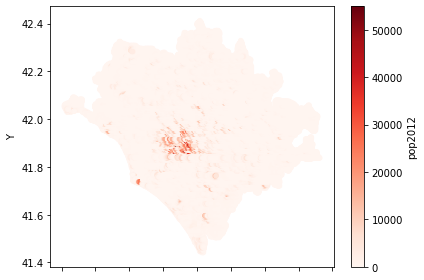

In [62]:
# Show the population distribution in Roma
Roma = data[data['city_id']==65]
Roma.plot(kind='scatter', x='X', y='Y', alpha=1, c='pop2012',cmap='Reds')
plt.tight_layout()

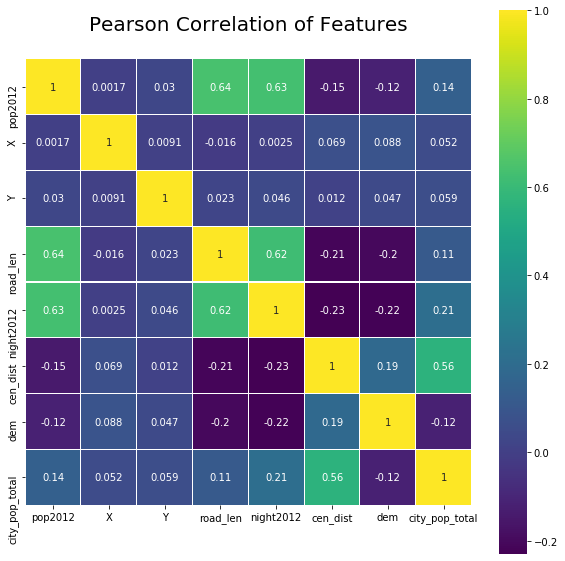

In [46]:
Correlation = pd.DataFrame(data_new[alist[2:]])

plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0,\
            square=True, cmap=plt.cm.viridis, linecolor='white', annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BA9E5C0B48>,
      dtype=object)

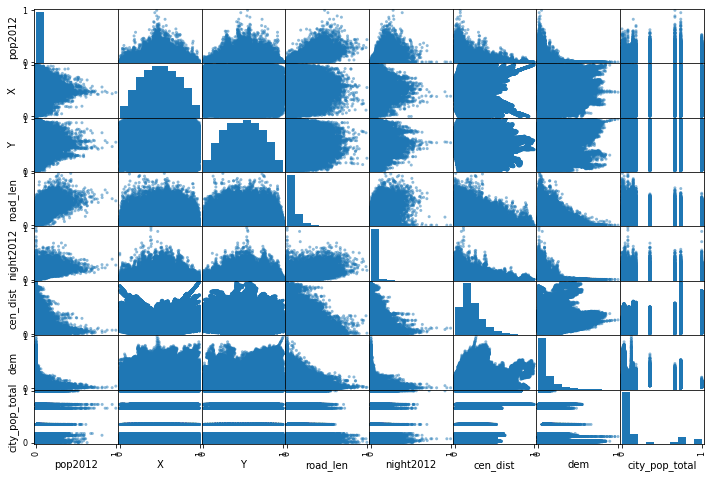

In [21]:
scatter_matrix(data_new[alist[2:]],figsize=(12,8))

In [47]:
def density_scatter(x, y, label, ax=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])), \
            data , np.vstack([x,y]).T, method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [52]:
x = data_new['road_len'].to_numpy()
y = data_new['night2012'].to_numpy()
z = data_new['pop2012'].to_numpy()

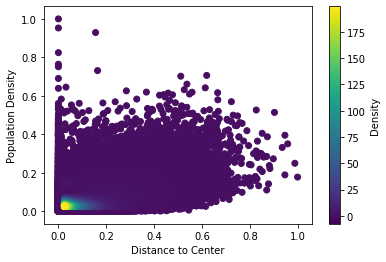

In [53]:
density_scatter(x, y, label=('Distance to Center','Population Density'), bins=[20,20])

In [54]:
# %matplotlib notebook
# # calling it a second time may prevent some graphics errors
# %matplotlib notebook 

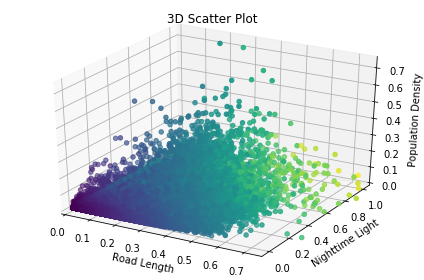

In [55]:
label=('Road Length','Nighttime Light','Population Density')

fig = plt.figure()
ax = plt.axes(projection='3d') 

X, Y, Z = x, y, z
c = X + Y

ax.scatter(X, Y, Z, c=c)
ax.set_xlabel(label[0])
ax.set_ylabel(label[1])
ax.set_zlabel(label[2])
ax.set_xlim([0, 0.75])
ax.set_zlim([0, 0.75])

ax.set_title('3D Scatter Plot') 
plt.tight_layout()

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + \
        np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    
    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [ ]:
data['cen_dist'] = haversine(data['X'],data['Y'],data['X_cen'],data['Y_cen'])